In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from spec_id import Oldest_galaxy,Likelihood_contours, Scale_model
from scipy.interpolate import interp1d,interp2d
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import grizli.model
from astropy.io import fits
import pandas as pd
from glob import glob
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.table import Table
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
%matplotlib inline

In [182]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [53]:
specz = 1.248
chifile = '../chidat/s39170_full_fit_d0_chidata.npy'
rshift,Pz = np.load('../chidat/s39170_full_fit_rs_pos.npy')

In [54]:
max_age = Oldest_galaxy(1.023)

####### Read in file   
chi = np.load(chifile)

chi[ : , len(age[age <= max_age]):,:,:] = 1E5

In [35]:
chi.T.shape

(41, 31, 56, 29)

In [61]:
rshift[20]

1.0229999999999999094

In [62]:
subchi = chi.T[20].T

In [45]:
subchi.shape

(29, 56, 31)

In [63]:

####### Get scaling factor for tau reshaping
ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))

convtable = np.load('../data/light_weight_scaling_3.npy')

overhead = np.zeros([len(tau),metal.size]).astype(int)
for i in range(len(tau)):
    for ii in range(metal.size):
        amt=[]
        for iii in range(age.size):
            if age[iii] > convtable.T[i].T[ii][-1]:
                amt.append(1)
        overhead[i][ii] = sum(amt)

######## get Pd and Pz
# P_full = np.exp(- chi / 2).astype(np.float128)

# P = np.trapz(P_full, rshift, axis=3)
P = np.exp(- subchi / 2).astype(np.float128)
new_P = np.zeros(P.T.shape)

######## Reshape likelihood to get light weighted age instead of age when marginalized
for i in range(len(tau)):
    frame = np.zeros([metal.size,age.size])
    for ii in range(metal.size):
        dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
        frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
    new_P[i] = frame.T

####### Create normalize probablity marginalized over tau
P = new_P.T

# test_prob = np.trapz(test_P, ultau, axis=2)
C = np.trapz(np.trapz(np.trapz(P, ultau, axis=2), age, axis=1), metal)

P /= C

prob = np.trapz(P, ultau, axis=2)

# #### Get Z, t, tau, and z posteriors
PZ = np.trapz(np.trapz(P, ultau, axis=2), age, axis=1)
Pt = np.trapz(np.trapz(P, ultau, axis=2).T, metal, axis=1)
Ptau = np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1)

[0, 0.03, 0, 6]

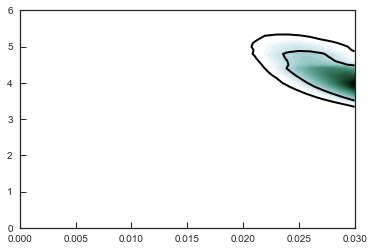

In [64]:
onesig,twosig = Likelihood_contours(age,metal,prob.T)
levels = np.array([twosig,onesig])

plt.contour(M,A,prob.T,levels,colors='k',linewidths=2)
plt.contourf(M,A,prob.T,40,cmap=cmap)
plt.axis([0,0.03,0,6])

[0, 0.03, 0, 6]

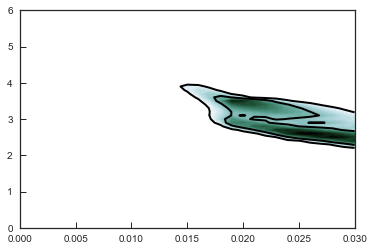

In [87]:
P2= np.load('../chidat/s39170_dtau_tZ_pos_lwa_3.npy')
onesig,twosig = Likelihood_contours(age,metal,P2)
levels = np.array([twosig,onesig])

plt.contour(M,A,P2,levels,colors='k',linewidths=2)
plt.contourf(M,A,P2,40,cmap=cmap)
plt.axis([0,0.03,0,6])

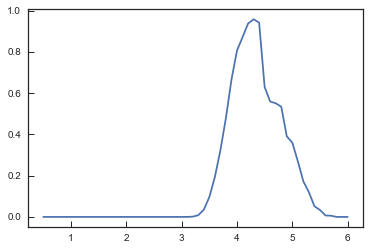

In [65]:
plt.plot(age,Pt)

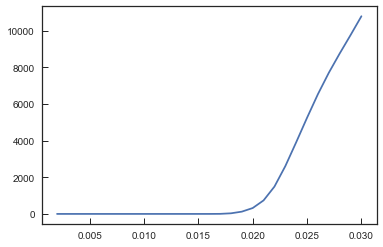

In [66]:
plt.plot(metal,PZ/0.019)

In [84]:
wv1,fl1,er1 = np.load('../spec_stacks/s39170.npy')
wv2,fl2,er2 = np.load('../spec_stacks_june14/s39170_stack.npy')

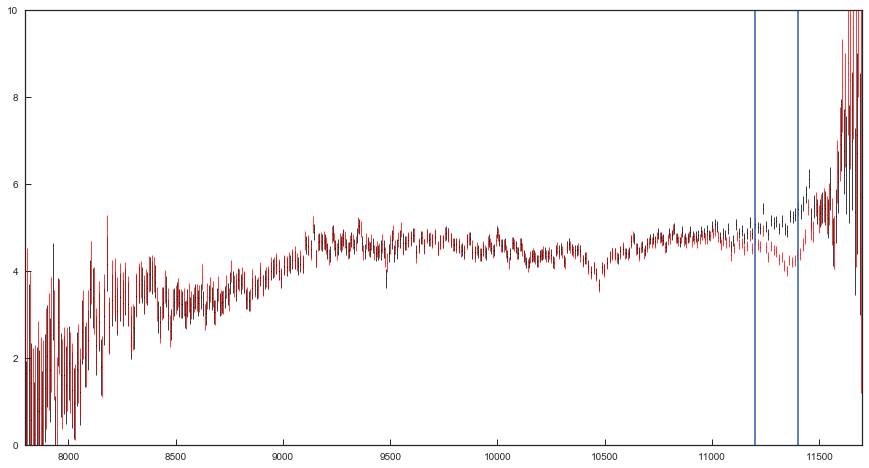

In [95]:
plt.figure(figsize=[15,8])
plt.errorbar(wv1, fl1*1E18*1.035, er1*1E18,linestyle='None', linewidth = 0.75, marker='o', markersize=1, color='k')
plt.errorbar(wv2, fl2*1E18, er2*1E18,linestyle='None', linewidth = 0.75, marker='o', markersize=1, color='r')
plt.axis([7800,11700,0,10])
plt.axvline(11200)
plt.axvline(11400)

In [88]:
ogdb = pd.read_pickle('../data/sgal_param_DB.pkl')
ngdb = pd.read_pickle('../data/upd_galDB.pkl')

In [144]:
cwv,corr = np.load('../data/reshape.npy')

In [184]:
for i in galDB.index:
    wv,fl,er = np.load('../spec_stacks/{0}.npy'.format(galDB.gids[i]))
    icorr = interp1d(cwv,corr)(wv)
    fl /= icorr
    er /= icorr    
    np.save('../spec_stacks/{0}'.format(galDB.gids[i]),[wv,fl,er])

In [185]:
class Gen_spec1(object):
    def __init__(self, galaxy_id, redshift,minwv = 7800, maxwv = 11200, shift = 1):
        self.galaxy_id = galaxy_id
        self.gid = int(self.galaxy_id[1:])
        self.redshift = redshift
        self.shift = shift

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.beam - information used to make models
        **
        self.wv - output wavelength array of simulated spectra
        **
        self.fl - output flux array of simulated spectra
        """
#         gal_wv, gal_fl, gal_er = np.load('../spec_stacks_june14/%s_stack.npy' % self.galaxy_id)

        gal_wv, gal_fl, gal_er = np.load(glob('../spec_stacks/*{0}*'.format(self.gid))[0])
        self.flt_input = glob('../beams/*{0}*'.format(self.gid))[0]

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]
    
#         icorr = interp1d(cwv,corr)(self.gal_wv)
        
#         self.gal_er /= icorr
#         self.gal_fl /= icorr
        
#         WV,TEF = np.load('../data/template_error_function.npy')
#         iTEF = interp1d(WV,TEF)(self.gal_wv_rf)
#         self.gal_er = np.sqrt(self.gal_er**2 + (iTEF*self.gal_fl)**2)

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(fits_file=self.flt_input)

        ## Get sensitivity function

        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,flat.shape[0]]),flat.T[:-1],axis=0).T , bin=0)
        
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, metal, age, tau, model_redshift = 0, dust = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
            
        model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal, age, tau)

        wave, fl = np.load(model)

        cal = 1
        if dust !=0:
            lam = wave * 1E-4
            Rv = 4.05
            k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
            cal = 10**(-0.4 * k * dust / Rv)  
        
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift),fl * cal])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        adj_ifl = ifl /self.filt
        
        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl
        
    def Sim_spec2(self, metal, age, tau, model_redshift = 0, dust = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
            
        model = '../../../fsps_models_for_fit/fsps_spec/m%s_a%s_dt%s_spec.npy' % (metal, age, tau)

        wave, flux = np.load(model)

        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift), flux])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)
        ifl = interp1d(w, f)(self.gal_wv)

        ## Get sensitivity function
        fwv, ffl = [self.beam.beam.lam, self.beam.beam.sensitivity / np.max(self.beam.beam.sensitivity)]
        filt = interp1d(fwv, ffl)(self.gal_wv)

        adj_ifl = ifl / filt

        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.mfl = C * adj_ifl

In [197]:
sp1 = Gen_spec1('n21156', 1.248,minwv=7800,maxwv=11100)
sp2 = Gen_spec1('n21156', 1.248,minwv=7800,maxwv=11100)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [198]:
chi1=[]
chi2=[]
for i in age:
    minichi1 = []
    minichi2 = []
    for ii in metal:
        sp1.Sim_spec(ii,i,8.0)
        sp2.Sim_spec2(ii,i,8.0)
        minichi1.append( np.sum(((sp1.gal_fl - sp1.fl)/ sp1.gal_er)**2) )
        minichi2.append( np.sum(((sp2.gal_fl - sp2.mfl)/ sp2.gal_er)**2) )    
    chi1.append(minichi1)
    chi2.append(minichi2)    

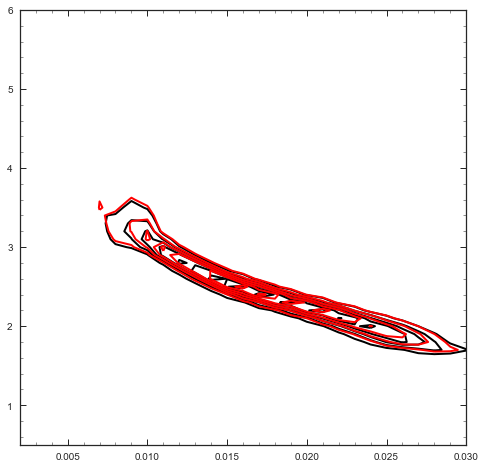

In [199]:
p1 = np.exp(-np.array(chi1)/2)
p2 = np.exp(-np.array(chi2)/2) 

plt.figure(figsize=[8,8])
plt.contour(M,A,p1,colors='k',linewidths=2)

# plt.figure(figsize=[8,8])
plt.contour(M,A,p2,colors='r',linewidths=2)


In [200]:
np.min(chi1),np.min(chi2)

(178.7522083025463, 179.01465018538585)

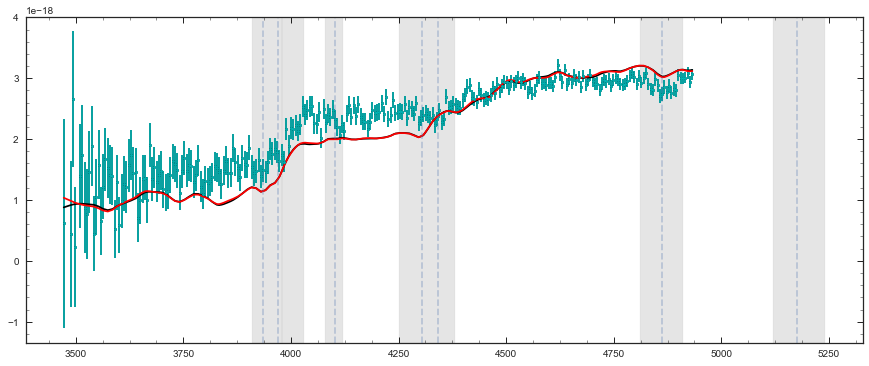

In [201]:
plt.figure(figsize=[15,6])
plt.errorbar(sp1.gal_wv_rf,sp1.gal_fl, sp1.gal_er,linestyle='None', marker='o', markersize=3, color='k', alpha=.9)
plt.errorbar(sp2.gal_wv_rf,sp2.gal_fl, sp2.gal_er,linestyle='None', marker='o', markersize=3, color='c', alpha=.9)
plt.plot(sp1.gal_wv_rf,sp1.fl,'k')
plt.plot(sp2.gal_wv_rf,sp2.mfl,'r')
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)

In [169]:
sp1.Sim_spec(0.019,2.0,8.0)
sp2.Sim_spec2(0.019,2.0,8.0)

In [171]:
model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(0.019,2.0,8.0)
wave, fl = np.load(model)

(3800, 5500)

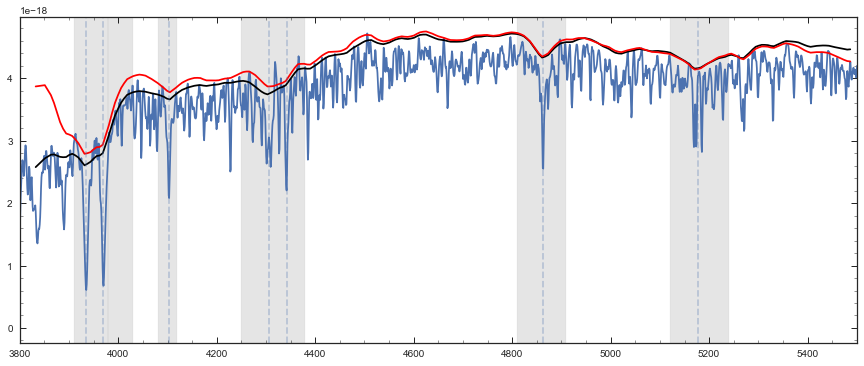

In [181]:
plt.figure(figsize=[15,6])
# plt.errorbar(sp1.gal_wv_rf,sp1.gal_fl, sp1.gal_er,linestyle='None', marker='o', markersize=3, color='k', alpha=.9)
# plt.errorbar(sp2.gal_wv_rf,sp2.gal_fl, sp2.gal_er,linestyle='None', marker='o', markersize=3, color='c', alpha=.9)
plt.plot(wave,fl*6E-14)
plt.plot(sp1.gal_wv_rf,sp1.fl,'k')
plt.plot(sp2.gal_wv_rf,sp2.mfl,'r')
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.xlim(3800,5500)

In [108]:
class Gen_spec2(object):
    def __init__(self, galaxy_id, redshift, minwv=7900, maxwv=11400, pad=100):
        import pysynphot as S
        self.galaxy_id = galaxy_id
        self.redshift = redshift
        self.pad = pad

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.pad - Grizli uses this to add extra pixels to the edge of an image to account for galaxies near the 
                   edge, 100 is usually enough
        **
        self.beam - information used to make models
        **
        self.gal_wv - output wavelength array of galaxy
        **
        self.gal_wv_rf - output wavelength array in restframe
        **
        self.gal_fl - output flux array of galaxy
        **
        self.gal_er - output error array of galaxy
        **
        self.fl - output flux array of model used for simulation
        **
        self.flx_err - output flux array of model perturb by the galaxy's 1 sigma errors
        **
        self.mfl - output flux array of model generated to fit against 
        """

        gal_wv, gal_fl, gal_er = np.load('../spec_stacks_june14/%s_stack.npy' % self.galaxy_id)
        self.flt_input = '../data/galaxy_flts/%s_flt.fits' % self.galaxy_id

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0]
        self.gal_wv = self.gal_wv[self.gal_fl > 0]
        self.gal_er = self.gal_er[self.gal_fl > 0]
        self.gal_fl = self.gal_fl[self.gal_fl > 0]

        ## Create Grizli model object
        sim_g102 = grizli.model.GrismFLT(grism_file='', verbose=False,
                                         direct_file=self.flt_input,
                                         force_grism='G102', pad=self.pad)

        sim_g102.photutils_detection(detect_thresh=.025, verbose=True, save_detection=True)

        keep = sim_g102.catalog['mag'] < 29
        c = Table.read('../data/galaxy_flts//%s_flt.detect.cat' % self.galaxy_id,format='ascii')
        sim_g102.catalog = c
        
        sim_g102.compute_full_model(ids=c['id'][keep], mags=c['mag'][keep], verbose=False)

        ## Grab object near the center of the image
        dr = np.sqrt((sim_g102.catalog['x_flt'] - 579) ** 2 + (sim_g102.catalog['y_flt'] - 522) ** 2)
        ix = np.argmin(dr)
        id = sim_g102.catalog['id'][ix]

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(sim_g102, beam=sim_g102.object_dispersers[id][2]['A'], conf=sim_g102.conf)

    def Sim_spec(self, metal, age, tau, model_redshift = 0, dust = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
            
        model = '../../../fsps_models_for_fit/fsps_spec/m%s_a%s_dt%s_spec.npy' % (metal, age, tau)

        wave, flux = np.load(model)

        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift), flux])
        
        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(self.beam.model, bin=0)

        ifl = interp1d(w, f)(self.gal_wv)

        ## Get sensitivity function
        fwv, ffl = [self.beam.beam.lam, self.beam.beam.sensitivity / np.max(self.beam.beam.sensitivity)]
        filt = interp1d(fwv, ffl)(self.gal_wv)

        adj_ifl = ifl / filt

        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.mfl = C * adj_ifl